In [118]:
#! /usr/bin/env python
# -*- coding: utf-8 -*-

import warnings; warnings.simplefilter('ignore')

import pandas as pd
import numpy as np

# Import CSVs with kDs and calculated properties
df_kd = pd.read_csv('name_SMILES_kd.csv', sep=',', encoding = 'ISO-8859-1')
df_cP = pd.read_csv('calculated_properties.csv', sep=',', encoding = 'ISO-8859-1')

# Merge dataframes and delete unwanted columns (e.g. comments and PubMed ID)
df = pd.concat([df_kd, df_cP], axis=1, join_axes=[df_kd.index])
df = df.drop(df.columns[[1, 2, 3, 4, 6, 8, 9, 10]], axis=1)

# Create labels based on kD.
cutoff = .1 # cutoff to divide good and not so good ligands (in micromolar) -- still to subjective...
df.insert(3, 'label', df['Kd'] )
df.insert(3, 'LogKd', np.log10(df['Kd']))
df['label'] = np.where(df['label'] >= cutoff, 1, 0)

X = df.drop(df.columns[[0, 1, 2, 3, 4]], axis=1)
y = df['label']

In [119]:
df.head(10)

,Ligand,Type,Kd,LogKd,label,apol,ast_fraglike,ast_fraglike_ext,ast_violation,ast_violation_ext,...,vsa_acid,vsa_base,vsa_don,vsa_hyd,vsa_other,vsa_pol,Weight,weinerPath,weinerPol,zagreb
0,Tobramycin,DNA,0.15000,-0.823909,1,69.069344,0,0,3,5,...,0.0,0,0.000000,168.441330,29.416998,166.562070,467.519990,2932,59,168
1,Melamine,DNA,0.51000,-0.292430,1,15.880758,1,0,0,1,...,0.0,0,53.227470,0.000000,47.044724,70.275200,126.123000,84,9,42
2,Ofloxacin,DNA,0.00011,-3.958607,0,52.080860,0,0,2,3,...,0.0,0,0.000000,256.576140,23.167019,43.204517,361.372990,1484,51,146
3,Gonyautoxin 1/4 (GTX1/4)Ê,DNA,0.01770,-1.752027,0,46.753483,0,0,3,5,...,0.0,0,41.167557,64.215599,70.687729,175.228790,411.351990,1588,53,154
4,Fluoroacetamide,DNA,25.00000,1.397940,1,8.646172,1,1,0,0,...,0.0,0,17.742489,34.529434,12.949531,31.309410,77.057999,18,2,16
5,Tyramine,DNA,0.20000,-0.698970,1,23.316723,1,1,0,0,...,0.0,0,0.000000,110.009040,0.000000,31.309410,137.181990,127,10,44
6,Patulin,DNA,0.02180,-1.661544,0,19.528757,1,1,0,0,...,0.0,0,0.000000,64.342522,31.920755,29.637598,154.121000,139,14,58
7,2.2_.4.4_-Tetrabromdiphenylether,DNA,0.00020,-3.698970,0,38.122757,0,0,2,2,...,0.0,0,0.000000,295.276250,2.503756,0.000000,485.794980,536,24,86
8,Chloramphenicol,DNA,0.03224,-1.491605,0,37.931515,0,0,1,2,...,0.0,0,5.682576,172.550540,53.711533,46.383339,323.131990,880,29,94
9,Mycolactone,RNA,1.59000,0.201397,1,131.333510,0,0,4,6,...,0.0,0,0.000000,639.706850,34.424511,94.968445,743.034970,15792,74,246


In [120]:
import warnings; warnings.simplefilter('ignore')

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix


seed = 42
test_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, 
                                                    random_state=seed)

classifier = XGBClassifier(booster='gbtree', gamma=0, learning_rate=.1, 
                           max_delta_step=1, max_depth=3, min_child_weight=1, 
                           n_estimators=100, n_jobs=1, random_state=42)
classifier.fit(X_train, y_train)

print(classifier)
print('')

# make predictions for test data
y_pred = classifier.predict(X_test)

# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# Calculate confusion matrix
y_pred_full = classifier.predict(X)
data = confusion_matrix(y, y_pred_full)
print('Confusion matrix')
print(data)
        

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=1,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

Accuracy: 60.53%
Confusion matrix
[[ 27  16]
 [  5 102]]


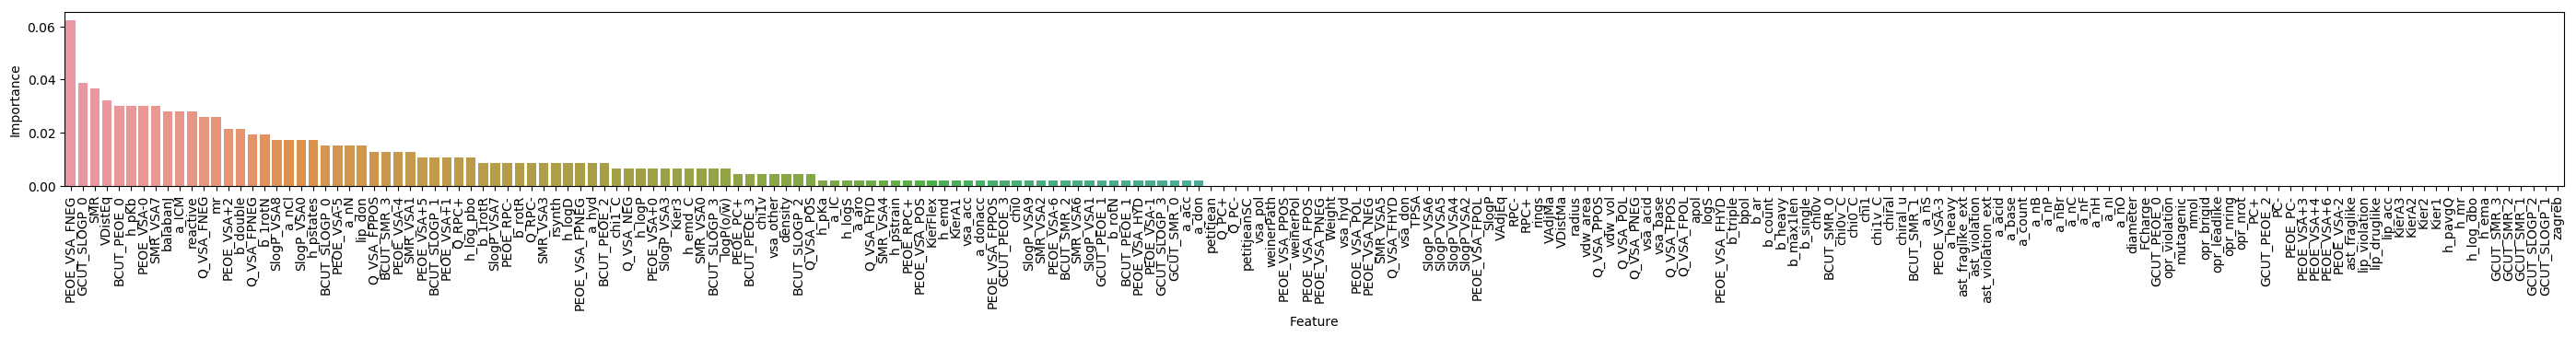

In [121]:
import matplotlib.pyplot as plt
import seaborn as sns

df_fi = pd.DataFrame(columns=['Feature','Importance'])
df_fi['Feature']    = X.columns.ravel()
df_fi['Importance'] = classifier.feature_importances_.ravel()
df_fi.sort_values('Importance', ascending=False, inplace=True)
df_fi.reset_index(inplace=True, drop=True)


plt.figure(figsize=[35,2.5], dpi=100)

#plt.xticks ([0])
ax = sns.barplot(x='Feature', y="Importance", data=df_fi)
for item in ax.get_xticklabels():
    item.set_rotation(90)

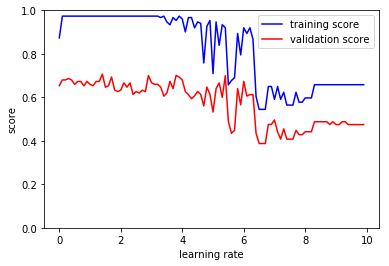

In [122]:
import numpy as np
from sklearn.model_selection import validation_curve

n_estimators = np.arange(1,200,10)
learning_rate = np.arange(0.0001, 10, 0.1)


train_score, val_score = validation_curve(classifier, X, y, 'learning_rate', learning_rate, cv=2)


# hier noch den graphischen Output einfügen
plt.plot(learning_rate, np.median(train_score, 1), color='blue', label='training score')
plt.plot(learning_rate, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0,1)
plt.xlabel('learning rate')
plt.ylabel('score');



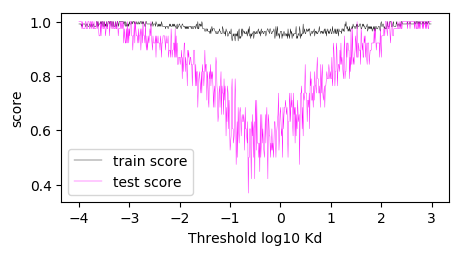

In [129]:
from sklearn.model_selection import cross_val_score



thresholds = np.arange(-4,3,0.01)
train_scores, test_scores = [], []
for threshold in thresholds:
    y = np.where(df['LogKd'] >= threshold, 1, 0)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25)
    
    clf = XGBClassifier(booster='gbtree', gamma=0, learning_rate=.1, 
                        max_delta_step=1, max_depth=3, min_child_weight=1, 
                        n_estimators=100, n_jobs=-1)
    
    #scores.append(cross_val_score(clf, X, y, cv=5, n_jobs=-1))
    clf.fit(X_train, y_train)
    train_scores.append(clf.score(X_train, y_train))
    test_scores.append(clf.score(X_test, y_test))

plt.figure(figsize=[5,2.5], dpi=100)
plt.plot(thresholds, train_scores, color='black', lw=0.3, label='train score')
plt.plot(thresholds, test_scores, color='magenta', lw=0.3, label='test score')

plt.legend(loc='lower left')
#plt.ylim(0.5,1.05)
plt.xlabel('Threshold log10 Kd')
plt.ylabel('score');


In [124]:
from sklearn.metrics import accuracy_score, confusion_matrix


y = np.where(df['LogKd'] >= -1.0, 1, 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, stratify=y)
    
clf = XGBClassifier(booster='gbtree', gamma=0, learning_rate=.1, 
                    max_delta_step=1, max_depth=3, min_child_weight=1, 
                    n_estimators=100, n_jobs=-1)

clf.fit(X_train, y_train)

# make predictions for test data
y_pred = clf.predict(X_test)

# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# Calculate confusion matrix
y_pred_full = clf.predict(X)
data = confusion_matrix(y, y_pred_full)
print('Confusion matrix')
print(data)
        
    

Accuracy: 63.16%
Confusion matrix
[[ 30  13]
 [  7 100]]


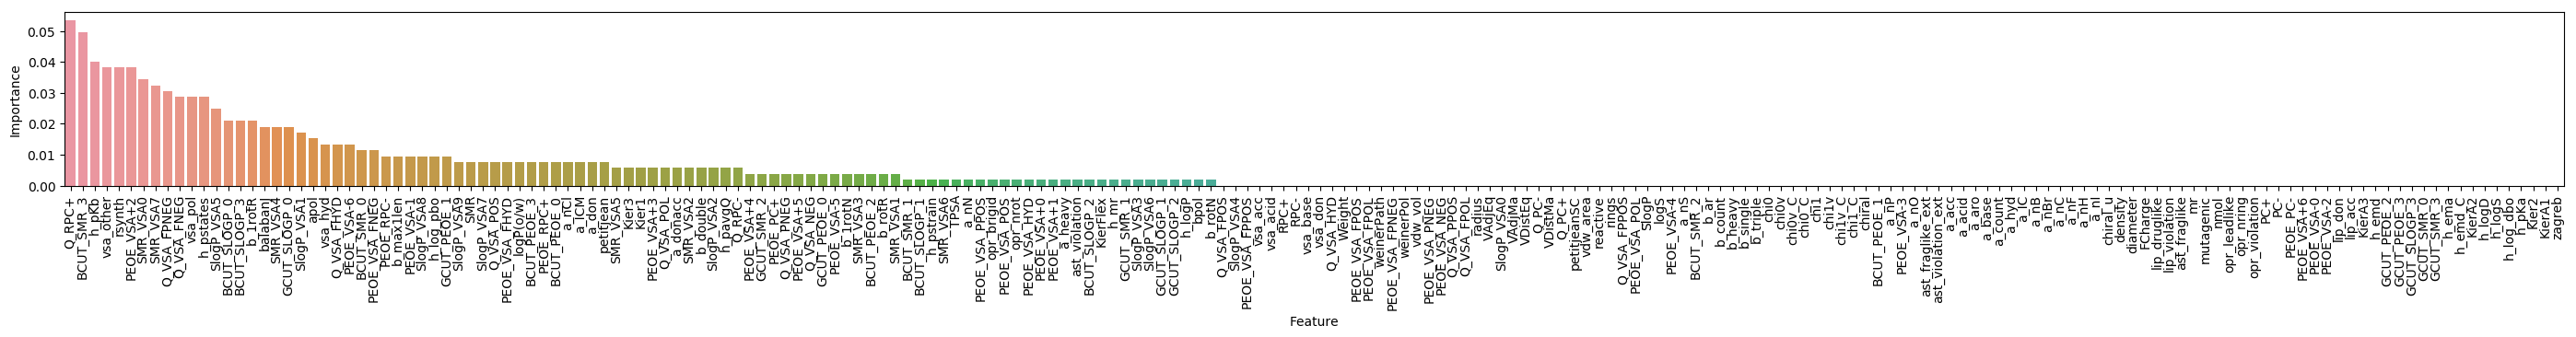

In [125]:
import matplotlib.pyplot as plt
import seaborn as sns

df_fi = pd.DataFrame(columns=['Feature','Importance'])
df_fi['Feature']    = X.columns.ravel()
df_fi['Importance'] = clf.feature_importances_.ravel()
df_fi.sort_values('Importance', ascending=False, inplace=True)
df_fi.reset_index(inplace=True, drop=True)


plt.figure(figsize=[35,2.5], dpi=100)

#plt.xticks ([0])
ax = sns.barplot(x='Feature', y="Importance", data=df_fi)
for item in ax.get_xticklabels():
    item.set_rotation(90)

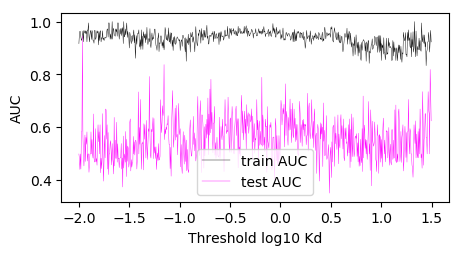

In [126]:
#from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score


thresholds = np.arange(-2.0,1.5,0.005)
train_AUC, test_AUC = [], []
for threshold in thresholds:
    y = np.where(df['LogKd'] >= threshold, 1, 0)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25)
    
    clf = XGBClassifier(booster='gbtree', gamma=0, learning_rate=.1, 
                        max_delta_step=1, max_depth=3, min_child_weight=1, 
                        n_estimators=100, n_jobs=-1)
    
    #scores.append(cross_val_score(clf, X, y, cv=5, n_jobs=-1))
    clf.fit(X_train, y_train)
    train_AUC.append( roc_auc_score(y_train, clf.predict(X_train)) )
    test_AUC.append( roc_auc_score(y_test, clf.predict(X_test)) )

plt.figure(figsize=[5,2.5], dpi=100)
plt.plot(thresholds, train_AUC, color='black', lw=0.3, label='train AUC')
plt.plot(thresholds, test_AUC, color='magenta', lw=0.3, label='test AUC')

plt.legend(loc='lower middle')
#plt.ylim(0.5,1.05)
plt.xlabel('Threshold log10 Kd')
plt.ylabel('AUC');


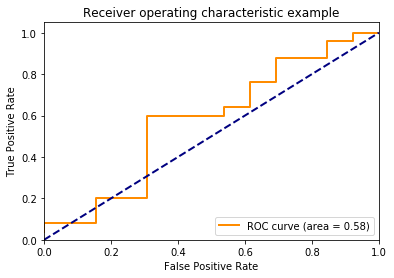

In [127]:
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import AdaBoostClassifier


#thresholds = np.arange(-2,1,1)
threshold = -1.0
y = np.where(df['LogKd'] >= threshold, 1, 0)

n_classes = y.shape[0]

clf = AdaBoostClassifier()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25)

y_score = clf.fit(X_train, y_train).decision_function(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:], y_score[:])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [128]:
# make predictions for test data
y_pred = clf.predict(X_test)

# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# Calculate confusion matrix
y_pred_full = classifier.predict(X)
data = confusion_matrix(y, y_pred_full)
print('Confusion matrix')
print(data)
        

Accuracy: 60.53%
Confusion matrix
[[ 27  16]
 [  5 102]]
